# Sader-Jarvis Force/Potential Conversion
## Author: Jeremiah Croshaw
#### Last Edited: Sept 23 2020

### This code is developed from work by [Huff](https://era.library.ualberta.ca/items/24288209-0dfe-4d67-81c3-67ab365b36b8) and [bendrevniok](https://github.com/bendrevniok/pySJ)
### Documentation regarding the derivation of the Force/Potential conversions can be found [here](https://doi.org/10.1063/1.1667267)
The included data files were taken by Jeremiah Croshaw while working with the [Wolkow Group](https://www.robertwolkow.com/) as a graduate student with the $\Delta f(z)$ spectroscopies published [here](https://www.beilstein-journals.org/bjnano/articles/11/119) and the resulting $F(z)$ and $U(z)$ plots used in Croshaw's PhD Thesis

author corresponence: croshaw@ualberta.ca

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from scipy.optimize import curve_fit
from scipy import integrate

#### extract_data_sxm(files)
extracts the recorded spectroscopic data from the .DAT file
***
input: 
- files .DAT file which contains the spectroscopic measurements of interest.  In this case, $\Delta f(z)$

output: two arrays 
- file_data is a 2D array where each column corresponds to a different channel in the .DAT file
- file_headers is a 1D array where each entry corresponds to the channel header from the .DAT file.



In [2]:
def extract_data_SXM(file):
    file_data = []
    file_headers = []
    lookup = '[DATA]' #all .DAT files separate the header and data with this string
    with open(file, encoding = "utf-8") as myFile:
        for num, line in enumerate(myFile, 1):
            if lookup in line: #when we find lookup, we know when the data starts and we can extract everything that follows
                #print ('found at line:', num+1)
                headerskip=num+1 #want it to skip one line past [DATA] since the header is one line past it. No text. Only floats.

    data=np.loadtxt(file,skiprows=headerskip,dtype=float) #read in the file using numpy's loadtxt. Auto skips header now and basically reads it into a giant array.
    file_data.append(data)
    ###READ IN THE HEADER### 
    with open(file,encoding = 'utf-8') as myFile:
        for i, line in enumerate(myFile):
            if i == headerskip-1:
                #print (line)
                datatitles=line.strip('\n')

    datatitles=datatitles.split('\t') #split from a single string into a 1D array anywhere there is a tab
    upper=len(datatitles)
    
    #some necessary array formatting.
    file_headers.append(datatitles)
    file_data = np.asarray(file_data,dtype = float)
    file_data = np.squeeze(file_data)
    file_data = np.swapaxes(file_data,0,1)
    file_headers = np.asarray(file_headers,dtype = str)
    file_headers = np.squeeze(file_headers)
    return file_data,file_headers

#### data_channel(file_data,file_headers,channel)
extracts a specific channel from all the collected data in the .DAT file
***
input:2 arrays, 1 string
- file_data is the same array as previous.  2d array with the extracted data from each channel
- file_headers is the same array as previous. 1d array with the data headers from each channel
- channel is a string used to select the channel of interest to extract from file_data

output: 3 arrays
- x_var is the x variable of interest (Z rel (m) or Bias calc (V))
- data_fwd is the channel of interest in the fwd scan direction
- data_bwd is the channel of interest in the bwd scan direction


In [3]:
def data_channel(file_data,file_headers,channel): #possible channels are 'freq','curr','bias','exci','phas','ampl','z'
    x_var = file_data[1]
    data_fwd = file_data[1]
    data_bwd = file_data[1]


# Note, the headers change for different version of Nanonis so you may have to adjust

    for i in range(0,len(file_headers)): # it will never have both of these headers
        if file_headers[i]=='Z rel (m)': #it's a z-spec measurment
            x_var = file_data[i]
        if file_headers[i]=='Bias calc (V)':  #it's a bias-spec measurement 
            x_var = file_data[i]

        if channel == 'freq':

            if file_headers[i]=='OC M1 Freq. Shift [bwd] (Hz)': #Cycles through datatitles and looks for keywords for the data, then reads the column in to a 1D array. Could add additional data types under if conditions if desired.
                data_bwd = file_data[i]
            if file_headers[i]=='OC M1 Freq. Shift (Hz)':
                data_fwd = file_data[i]

        elif channel == 'curr':   
            
            if file_headers[i]=='Current [bwd] (A)':   
                data_bwd = file_data[i]
            if file_headers[i]=='Current (A)':   
                data_fwd = file_data[i]  
                
        elif channel == 'exci':
            
            if file_headers[x][i]=='OC M1 Excitation (V)':   
                data_fwd = file_data[i]
            if file_headers[x][i]=='OC M1 Excitation [bwd] (V)\n':   
                data_bwd = file_data[i]
    
        elif channel == 'bias':
            
            if file_headers[x][i]=='Bias (V)':   
                data_fwd = file_data[i]
            if file_headers[x][i]=='Bias [bwd] (V)':   
                data_bwd = file_data[i]

        elif channel == 'phas':
            
            if file_headers[x][i]=='Phase (deg)':   
                data_fwd = file_data[i]
            if file_headers[x][i]=='Phase [bwd] (deg)':   
                data_bwd = file_data[i]
        
        elif channel == 'ampl':
            
            if file_headers[x][i]=='Amplitude (m)':   
                data_fwd = file_data[i]
            if file_headers[x][i]=='Amplitude [bwd] (m)':   
                data_bwd = file_data[i]
        
        elif channel == 'z':
            
            if file_headers[x][i]=='Z (m)':   
                data_fwd = file_data[i]
            if file_headers[x][i]=='Z [bwd] (m)':   
                data_bwd = file_data[i]
        else:
            print('channel not found.  It is broken')
            
        x_var = np.asarray(x_var,dtype = float)
        data_fwd = np.asarray(data_fwd, dtype = float)
        data_bwd = np.asarray(data_bwd, dtype = float)
    return x_var,data_fwd,data_bwd

#### force_conversion(zdist,freq):
converts the $\Delta f(z)$ data to $F(z)$
***
input:two 1D arrays
- zdist is the z data from the $\Delta f(z)$
- freq is the $\Delta f$ data from the $\Delta f(z)$

output: two 1D arrays
- zout is the z data which has been resized to match the corresponding F array
- force is the calculated F data

In [4]:
def force_conversion(zdist,freq):
    #Si tip
    f0 = 25068 # resonant frequency of tip (Hz)
    k = 1800 #spring constant of cantilever (N/m)
    A = 50e-12 #oscillation amplitude (pm)
    """
    #H tip
    f0 = 32673 #Hz
    k = 1800 #N/m
    A = 50e-12 
    """
    zdist = np.flip(zdist)

    df = np.flip(freq)
    z = zdist
    #print(z)
    force = np.zeros(np.size(df)-2) # we lose two points from the derivative calculation

    #calculate the simple derivative as (df[i+1]-df[i])/(z[i+1]-z[i])
    ddf_dz = np.diff(df)/np.diff(z)

    for i in range(np.size(z)-2):

        #integration range z_prime offset by one
        z_diff = z[i+1:-1] - z[i]
        #set up the integrand and then integrate with trapezoid
        integrand =(1+((np.sqrt(A))/(8*np.sqrt(np.pi*(z_diff)))))*df[i+1:-1]-(A**(3.0/2)/(np.sqrt(2*(z_diff))))*ddf_dz[i+1::]

        integral = np.trapz(integrand, z_diff+z[i])
        
        #add some correction factors following bendrevniok
        #these corrections are added to correct for dissipative forces (doi:10.1088/0957-4484/16/3/018)
        corr_1 = df[i]*np.diff(z)[i]
        corr_2 = 2*(np.sqrt(A)/(8*np.sqrt(np.pi)))*df[i]*np.sqrt(np.diff(z)[i])
        corr_3 = (-2)*((A**(3.0/2))/np.sqrt(2))*ddf_dz[i]*np.sqrt(np.diff(z)[i])

        #make the total force and add it to the force array
        force[i] = ((2*k)/f0) *(corr_1+corr_2+corr_3+integral)

    zout = z[:np.size(force)]
    return zout,force

#### potential_conversion(zdist,freq)
converts the $\Delta f(z)$ data to $U(z)$ by integrating $F(z)$.
***
input:two 1D arrays
- zdist is the z data from the $\Delta f(z)$
- freq is the $\Delta f$ data from the $\Delta f(z)$

output: two 1D arrays
- zout is the z data which has been resized to match the corresponding F array
- potential is the calculated U data

In [5]:
def potential_conversion(zdist,freq):
    
    zout, force = force_conversion(zdist,freq)
    potential = -1.*integrate.cumtrapz(np.flip(force),np.flip(zout),initial = 0) #need to flip to calc. integral in right direction
    zout = zout[:len(potential)]
    potential = np.flip(potential*6.242e18) #convert to eV
    return zout, potential

#### Fitting Function Used
***
lj: Leaonard Jones potential -> the number in the exponent was varied to find best fit

morse: Morse Potential

RSS: Residual Sum of Squares -> used to determine the best fit when varying the exponent in LJ

In [6]:
def lj(z,a,b,c):
    att = a + b/((z+700)**7) + c/((z+700)**3)
    return att

# if running the modification marked below
def lj_recursive(z,r_1,r_2,a,b,c):
    att = a + b/((z+700)**r_1) + c/((z+700)**r_2)
    return att

def morse(z,d,a,r):
    u = d*(np.exp(-2*a*(z-r-700))-2*np.exp(-a*(z-r-700)))
    return u
def RSS(y,f):
    rss = np.sum(np.square(y-f))
    return rss

### Main Code

Here I am just showing an example of plotting the Si apex $F(V)$ spectroscopy and plotting a L-J type fit.
The information in here can be tuned to plot the H apex $F(V)$, and $U(V)$ and Si apex $U(V)$ spectroscopies as well
fits of varying forms and powers

popt:
 [ 1.70847073e-03 -5.51269746e+16  3.64906113e+06]
perr:
  [9.54641611e-04 1.10845410e+15 1.68924227e+05]
rss:2.104416088684413


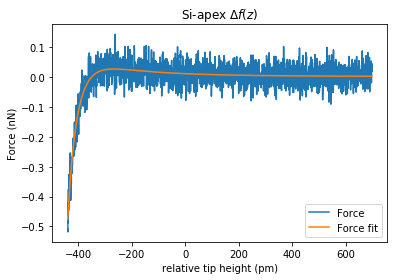

In [7]:
channel = 'freq' #possible channels are 'freq','curr','bias','exci','phas','ampl','z'
#file1 = ".\\H_apex\\Z-Spectroscopy00005.DAT" #over H
#file2 = ".\\H_apex\\Z-Spectroscopy00006.DAT" # over background
# file Z-Spec...07.DAT is intradimer position

file1 = ".\\Si_apex\\Z-Spectroscopy00011.DAT" #over H
file2 = ".\\Si_apex\\Z-Spectroscopy00015.DAT" # over background
# file Z-Spec...14.DAT is intradimer position

#extract data from files
file1_data,file1_headers = extract_data_SXM(file1)      

file2_data,file2_headers = extract_data_SXM(file2)

#print(file1_headers.shape)

#extract desired channel
x_var1,data1_fwd,data1_bwd = data_channel(file1_data,file1_headers,'freq')

x_var2,data2_fwd,data2_bwd = data_channel(file2_data,file2_headers,'freq')
 
# convert to force
z1,force1 = force_conversion(x_var1,data1_fwd)
z2,force2 = force_conversion(x_var2,data2_fwd)

#convert to potential
z1,potential1 = potential_conversion(x_var1,data1_fwd)
z2,potential2 = potential_conversion(x_var2,data2_fwd)

# the convergence of the fit depends on the intialization.  Might need to spend some time playing with these.
popt,pcov = curve_fit(lj,z1*1e12,(force1-force2)*1e9,[1.70847073e-03,-5.51269746e+16,3.64906113e+06],maxfev = 1000000)
#popt,pcov = curve_fit(morse,z1*1e12,(potential1-potential2),[-100,-0.0005,0],maxfev = 1000000)

for x in range(0,100): # I found it useful to run this a few times to ensure convergence on a good fit.  Might be overkill
    popt,pcov = curve_fit(lj,z1*1e12,(force1-force2)*1e9,popt,maxfev = 1000000)
    #print(x)



print("popt:\n",popt)
perr = np.sqrt(np.diag(pcov)) #calculate error from covariance
print("perr:\n ",perr)
force_fit = lj(z1*1e12,*popt)
#print(force_fit)
print("rss:" + str(RSS(force_fit,(force1-force2)*1e9)))



#print(force)

#plt.figure(1, dpi=100, facecolor='k', edgecolor='k') #define figure params
plt.plot(z1/(10**(-12)),(force1-force2)*1e9,label="Force")
#plt.plot(z1/(10**(-12)),(potential1-potential2),label="Potential")
#plt.plot(x_var1/(10**(-12)),(data1_fwd-data2_fwd),label="Potential")

plt.plot(z1*1e12,force_fit,label="Force fit")

plt.title(r'Si-apex $\Delta f(z)$')
plt.xlabel('relative tip height (pm)')
plt.ylabel('Force (nN)')
plt.legend()

plt.show()

#### Recursive Modification
When running the fits with varying LJ powers, it was useful to do this recursively.  
The RSS is saved to an array to be plotted later.

In [8]:
rss_array = [] #define empty list for saving RSS values
for r_1 in range(0,15):
    print(r_1)
    for r_2 in range(0,15):
        #force
        popt,pcov = curve_fit(lambda z,a,b,c: lj_recursive(z,r_1,r_2,a,b,c),z1*1e12,(force1-force2)*1e9,[1.70847073e-03,-5.51269746e+16,3.64906113e+06],maxfev = 1000000) # note that the shape of the seaborn plot greatly depends on these initial values.  They are worth playing around with a bit.
        popt,pcov = curve_fit(lambda z,a,b,c: lj_recursive(z,r_1,r_2,a,b,c),z1*1e12,(force1-force2)*1e9,[popt[0],popt[1],popt[2]],maxfev = 1000000) # this can be iterated over again if needed.
        force_fit = lj_recursive(z1*1e12,r_1,r_2,*popt)
        rss = RSS(force_fit,(force1-force2)*1e9)
        rss_array.append([r_1,r_2,rss])
        

0


c:\users\crosh\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


#### Plotting the rss_array

Since plotting the array doesn't really provide insights into how well the curve fits at the onset of the repulsive interaction, the plots used in the thesis were selected by eye looking for the best fit in the at the far left of the plot

The same thing can be done for the potential, just change all references of force to potential.

(15, 15)


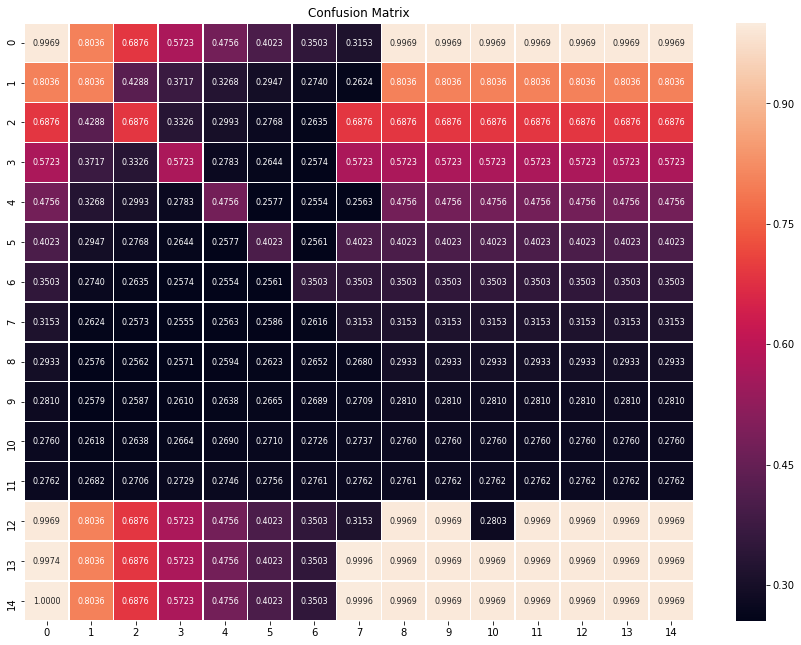

In [9]:
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd 
from matplotlib.colors import LogNorm

r_1 = np.transpose(rss_array)[0]
r_2 = np.transpose(rss_array)[1]
rss = np.transpose(rss_array)[2]
rss_norm = rss/np.max(rss)
rss_norm = np.resize(rss_norm,(15,15))
print(rss_norm.shape)
labels = str(r_1)
#df = pd.DataFrame(rss_norm,columns = labels,rows = labels)


f, ax = plt.subplots(figsize=(15,11))
sns.heatmap(rss_norm,annot=True, fmt="0.4f", linewidth = 0.5,annot_kws = {'size':8}, ax= ax ) #norm = LogNorm()
plt.title("Confusion Matrix")
plt.show()
